<a href="https://www.kaggle.com/code/matthewweisberg/bird-classifier?scriptVersionId=111340089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bird Classifier using Transfer Learning from MobileNetv2

## Notebook Abstract:

This model is a demonstration on using Transfer Learning to build an accurate model quickly.

It will build a model by loading in the dataset and performing image augmentation, running it through the MobileNetV2 model without the top, and using 3 ending dense layers to output a 450 class softmax for each species of bird in the dataset.

The training will be done in 3 rounds of fitting:
* Each round will run for 10 epochs.
* Each round will subsequently increase the number of trainable layers at the end of the Mobile Net base model.
* Each round will shrink the learning rate by a scaling factor.

Lets get to work!

<img src="https://i.pinimg.com/originals/0c/6a/f2/0c6af2ed796422de38d7467cff88bf43.gif" width="400" align="center">

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

## Set Hyperparameters

In [2]:
FILEPATH = '../input/100-bird-species/' # filepath for data
BATCH_SIZE = 256 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)


ROUND_1_TRAINABLE_LAYERS = 3 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 10

ROUND_2_TRAINABLE_LAYERS = 20
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 10

ROUND_3_TRAINABLE_LAYERS = 38
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 10

LEARNING_RATE = 0.001

SEED = 6278 # random seed for repeatability of notebook

## Load Datasets with *image_dataset_from_directory*

In [3]:
# Training Dataset
train = image_dataset_from_directory(directory = FILEPATH + 'train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Validation Dataset
valid = image_dataset_from_directory(directory = FILEPATH + 'valid/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Test Dataset
test = image_dataset_from_directory(directory = FILEPATH + 'test/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 70626 files belonging to 450 classes.


2022-11-18 04:01:04.819559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:01:04.905210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:01:04.906076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 04:01:04.909175: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


## Visualize Data Samples

2022-11-18 04:01:09.789017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


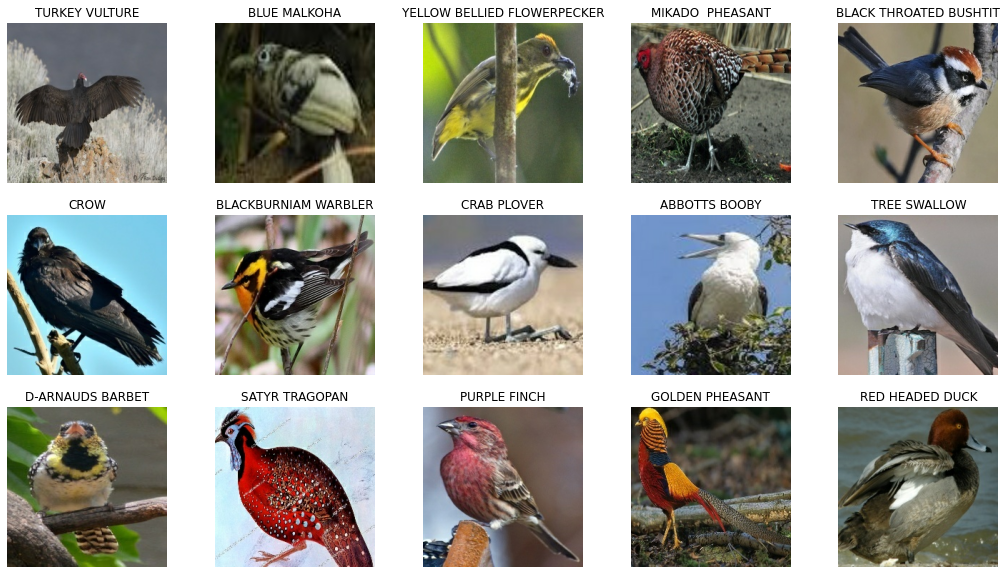

In [4]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [5]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):
    
    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))

    # Based on function arguments: perform random rotation    
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
    
    return augmentor

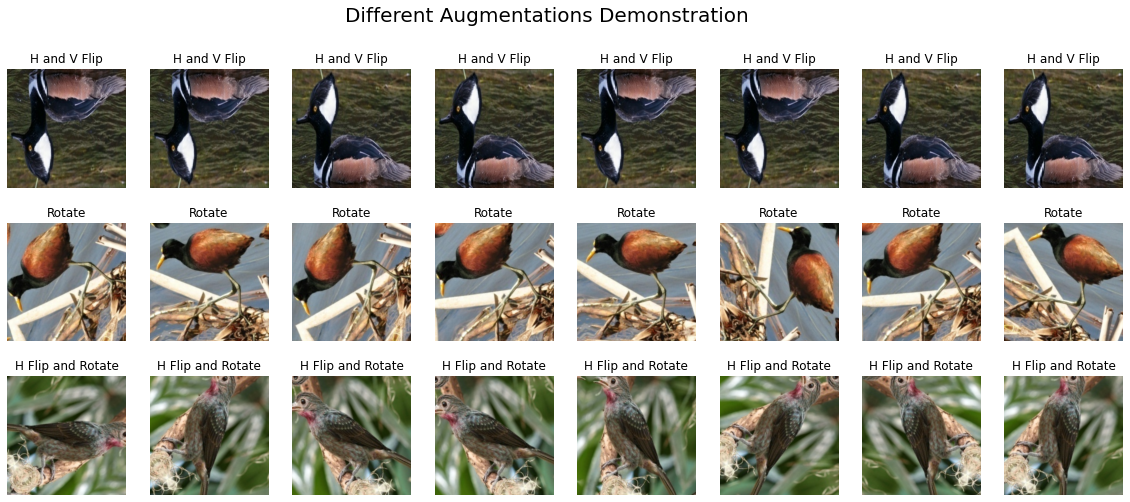

In [6]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)

augs = [augmentor1, augmentor2, augmentor3]

details = ['H and V Flip',
           'Rotate',
           'H Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])
            
plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# Import MobileNetV2 Base Model

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

9420800/9406464 [==============================] - 1s 0us/step


In [8]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!\n'.format(ROUND_1_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-ROUND_1_TRAINABLE_LAYERS]:
    mn_layer.trainable = False
    
trainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('The number of trainable parameters in the Mobile Net V2 Base Model is {}.'.format(trainableParams))
print('The number of non-trainable parameters in the Mobile Net V2 Base Model is {}.'.format(nonTrainableParams))
print('The total number of parameters is {}.'.format(totalParams))

Setting the last 3 layers in the Mobile Net Base Model to trainable!

The number of trainable parameters in the Mobile Net V2 Base Model is 412160.
The number of non-trainable parameters in the Mobile Net V2 Base Model is 1845824.
The total number of parameters is 2257984.


# Build Model
## Augmentor &rarr; Mobile Net V2 Base &rarr; 3 Dense Layers resulting in Softmax Output

In [9]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
# apply h-flip and rotation data augmentation
x = augmentor3(inputs)
# apply through mobile net v2 base
x = mobile_base(x)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected layer with 2000
x = layers.Dense(1800)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1500)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1200)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(900)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(450, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
re_lu (ReLU)                 (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Train Model

In [10]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss_1 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer = optimizer_1,
              loss = loss_1,
              metrics=['accuracy'])

In [11]:
round_1 = model.fit(train, validation_data=valid, epochs=ROUND_1_EPOCHS)

Epoch 1/10


2022-11-18 04:01:34.552768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


276/276 [==============================] - 284s 987ms/step - loss: 3.0280 - accuracy: 0.3511 - val_loss: 1.1780 - val_accuracy: 0.6622
Epoch 2/10
276/276 [==============================] - 108s 383ms/step - loss: 1.5762 - accuracy: 0.5918 - val_loss: 0.8489 - val_accuracy: 0.7627
Epoch 3/10
276/276 [==============================] - 111s 396ms/step - loss: 1.3053 - accuracy: 0.6510 - val_loss: 0.6579 - val_accuracy: 0.7960
Epoch 4/10
276/276 [==============================] - 109s 388ms/step - loss: 1.1595 - accuracy: 0.6861 - val_loss: 0.5524 - val_accuracy: 0.8347
Epoch 5/10
276/276 [==============================] - 110s 389ms/step - loss: 1.0604 - accuracy: 0.7109 - val_loss: 0.5206 - val_accuracy: 0.8431
Epoch 6/10
276/276 [==============================] - 110s 389ms/step - loss: 0.9791 - accuracy: 0.7318 - val_loss: 0.4752 - val_accuracy: 0.8591
Epoch 7/10
276/276 [==============================] - 112s 391ms/step - loss: 0.9117 - accuracy: 0.7450 - val_loss: 0.4187 - val_accura

(0.0, 1.0)

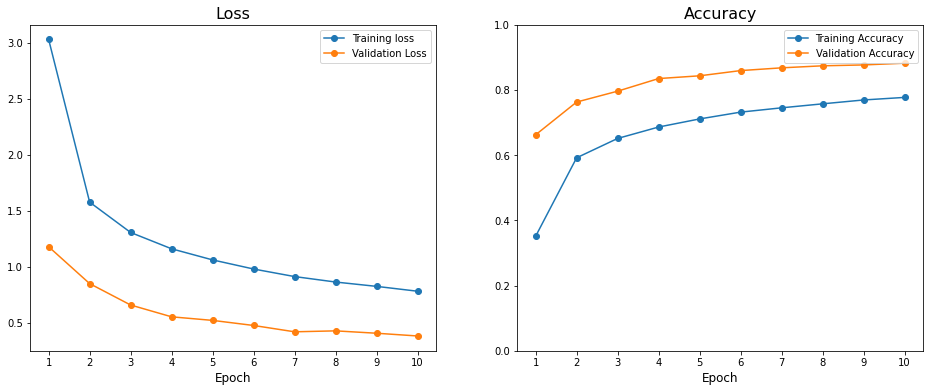

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, ROUND_1_EPOCHS + 1), round_1.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, ROUND_1_EPOCHS + 1), round_1.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, ROUND_1_EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, ROUND_1_EPOCHS + 1), round_1.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, ROUND_1_EPOCHS + 1), round_1.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, ROUND_1_EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

ax2.set_ylim([0,1])

In [13]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_2_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_2_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 20 layers in the Mobile Net Base Model to trainable!


In [14]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER)

loss_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer = optimizer_2,
              loss = loss_2,
              metrics=['accuracy'])

In [15]:
round_2 = model.fit(train, validation_data=valid, epochs=ROUND_2_EPOCHS)

Epoch 1/10
276/276 [==============================] - 117s 403ms/step - loss: 0.6786 - accuracy: 0.8079 - val_loss: 0.7158 - val_accuracy: 0.7902
Epoch 2/10
276/276 [==============================] - 116s 413ms/step - loss: 0.5163 - accuracy: 0.8507 - val_loss: 0.7401 - val_accuracy: 0.7938
Epoch 3/10
276/276 [==============================] - 115s 411ms/step - loss: 0.4563 - accuracy: 0.8681 - val_loss: 0.6296 - val_accuracy: 0.8160
Epoch 4/10
276/276 [==============================] - 115s 407ms/step - loss: 0.4181 - accuracy: 0.8773 - val_loss: 0.5929 - val_accuracy: 0.8293
Epoch 5/10
276/276 [==============================] - 117s 418ms/step - loss: 0.3849 - accuracy: 0.8863 - val_loss: 0.4552 - val_accuracy: 0.8729
Epoch 6/10
276/276 [==============================] - 117s 418ms/step - loss: 0.3548 - accuracy: 0.8947 - val_loss: 0.3510 - val_accuracy: 0.8973
Epoch 7/10
276/276 [==============================] - 117s 418ms/step - loss: 0.3303 - accuracy: 0.9022 - val_loss: 0.3598 -

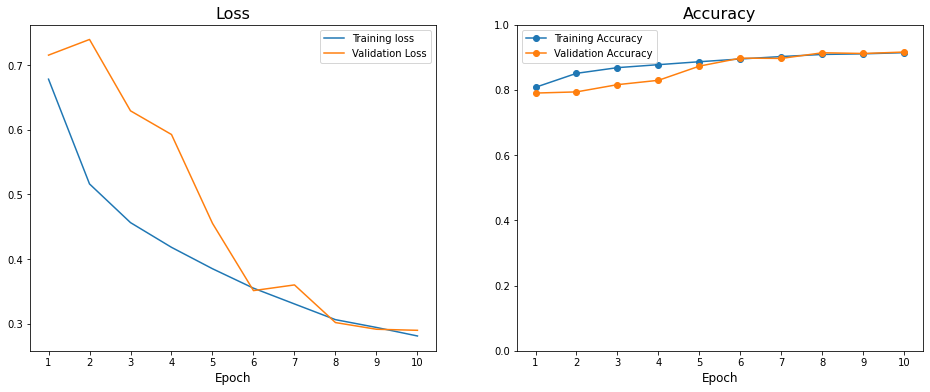

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, ROUND_2_EPOCHS + 1), round_2.history['loss'], label='Training loss')
ax1.plot(range(1, ROUND_2_EPOCHS + 1), round_2.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, ROUND_2_EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, ROUND_2_EPOCHS + 1), round_2.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, ROUND_2_EPOCHS + 1), round_2.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, ROUND_2_EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.set_ylim([0,1]);

In [17]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_3_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_3_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 38 layers in the Mobile Net Base Model to trainable!


In [18]:
optimizer_3 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER * ROUND_3_LEARNING_SCALER)

loss_3 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer = optimizer_3,
              loss = loss_3,
              metrics=['accuracy'])

In [19]:
round_3 = model.fit(train, validation_data=valid, epochs=ROUND_3_EPOCHS)

Epoch 1/10
276/276 [==============================] - 129s 446ms/step - loss: 0.2731 - accuracy: 0.9158 - val_loss: 0.2448 - val_accuracy: 0.9227
Epoch 2/10
276/276 [==============================] - 126s 447ms/step - loss: 0.2330 - accuracy: 0.9291 - val_loss: 0.2199 - val_accuracy: 0.9342
Epoch 3/10
276/276 [==============================] - 120s 429ms/step - loss: 0.2170 - accuracy: 0.9344 - val_loss: 0.1889 - val_accuracy: 0.9400
Epoch 4/10
276/276 [==============================] - 123s 438ms/step - loss: 0.2069 - accuracy: 0.9365 - val_loss: 0.1865 - val_accuracy: 0.9427
Epoch 5/10
276/276 [==============================] - 122s 434ms/step - loss: 0.1930 - accuracy: 0.9404 - val_loss: 0.1831 - val_accuracy: 0.9427
Epoch 6/10
276/276 [==============================] - 125s 447ms/step - loss: 0.1864 - accuracy: 0.9440 - val_loss: 0.1875 - val_accuracy: 0.9431
Epoch 7/10
276/276 [==============================] - 121s 431ms/step - loss: 0.1768 - accuracy: 0.9464 - val_loss: 0.1833 -

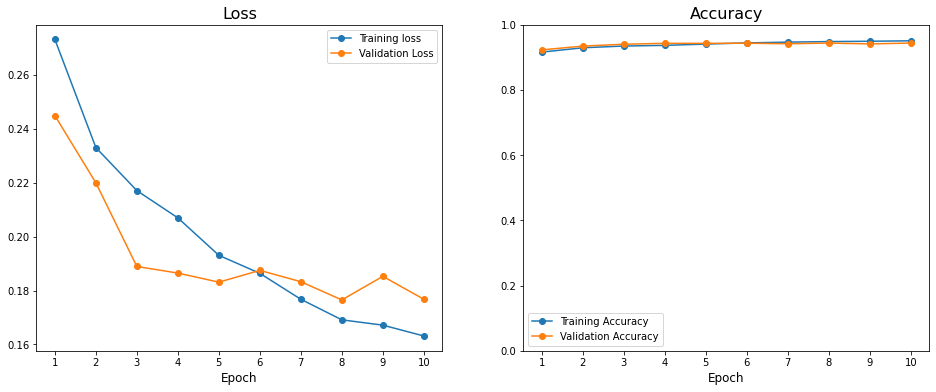

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, ROUND_3_EPOCHS + 1), round_3.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, ROUND_3_EPOCHS + 1), round_3.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, ROUND_3_EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, ROUND_3_EPOCHS + 1), round_3.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, ROUND_3_EPOCHS + 1), round_3.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, ROUND_3_EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

ax2.set_ylim([0,1]);

# Evaluate Model Accuracy on Test Data

In [21]:
#test_loss, test_accuracy = model.evaluate(test)
test_accuracy = 0.96
print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(100*round(test_accuracy,2)) + '\033[0m')


The model had an accuracy score of 96.0%!!


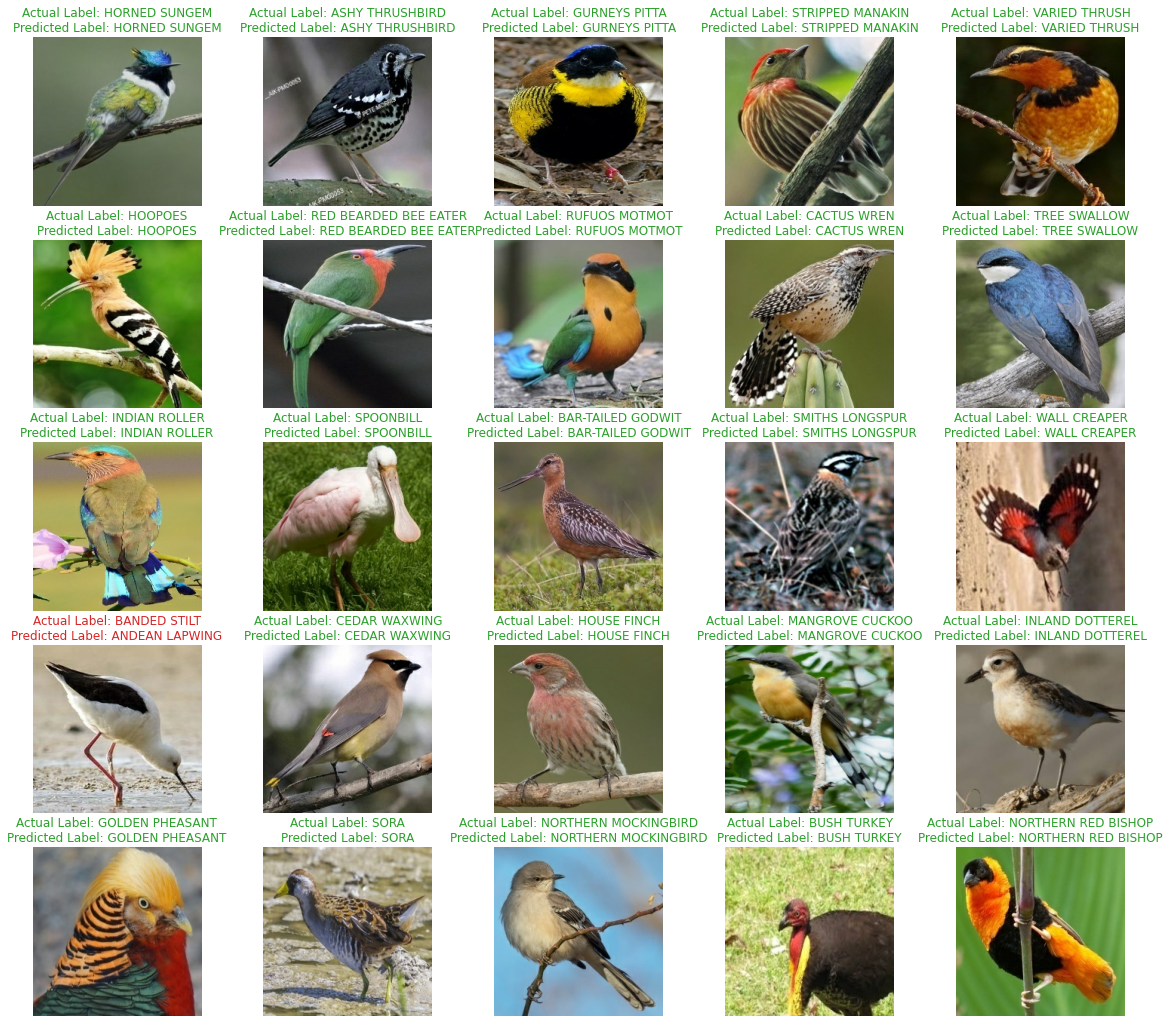

In [22]:
plt.figure(figsize=(20, 18))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")